# Demonstrating Provenance for netcdf/xarray workflows.


Authors: Alessandro Spinuso and Andrej Mihajlovski
Royal Netherlands Meteorologic Institure (KNMI)


The following demonstration focuses on presenting provenance using PROV-S and W3C for a simple workflow using dataset input and output elements.

The dispel4py framework is utalised for the workflows. 
Xarray for inmemory management of netcdf/opendap data.
Matplotlib for visualisation.
W3C for provenance representation.

In [1]:
import xarray
#import netCDF4
import json

from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *

import time
import random

from dispel4py.base import create_iterative_chain, ConsumerPE, IterativePE, SimpleFunctionPE

import matplotlib.pyplot as plt
import traceback

Simple Workflow, xarray in xarray out. 
The generic processing elements are defined bellow. GenericPE bellongs to the dispel4py framework. It allows pickeled elements to be passed as inputs and outputs. The elements are linked and visualised via the workflow_graph component.
The three components defined bellow:
- Read, xarray is read into memory.
- Workflow, xarray is processed/passed to output (no changes)
- Write, xarray is visualised.

SETTING NAME: Read
SETTING NAME: Workflow
SETTING NAME: Write


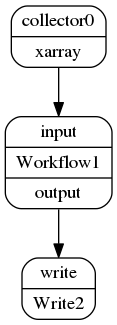

In [2]:
class Read(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('xarray')

    def _process(self,inputs):
        self.log('read_process')
     
        self.log(inputs)

        ds = xarray.open_dataset(inputs['input'][0])
    
        self.write( 'xarray' , (ds , inputs['input'][1]) )

class Write(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('write')
        self._add_output('end')
        
    def _process(self,inputs):
        self.log('WriteFunction')
        
        inputs['write'][0].to_netcdf( inputs['write'][1] )
        
        self.write('end', inputs )
        
        
class Workflow(GenericPE):
        
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output')
        
    def _process(self,inputs):
        self.log('Workflow_process')
        
        #self.log(inputs)
        
        #nc = inputs['input'][0]
        nc = inputs['input'][0]
        #self.log(nc)
        #
        self.write('output', (nc , inputs['input'][1] ))


readX  = Read()
readX.name = 'collector'
wf     = Workflow()       
writeX = Write()

#Initialise the graph
def createWorkflowGraph():
    graph = WorkflowGraph()    
    graph.connect(readX ,'xarray'   , wf     ,'input')
    graph.connect(wf    ,'output'   , writeX , 'write')

    return graph

graph = createWorkflowGraph()


from dispel4py.visualisation import display
display(graph)


def runExampleWorkflow():
    infile = 'input_simple.json'
    #with open(infile) as data_file:    
    #    input_data = json.load(data_file)
    
    print infile                                                     
    print input_data                   

    #Launch in simple process
    simple_process.process_and_return(graph, input_data)

Input specified.

In [3]:
input_data = { 
                'collector': [ { 'input': [ 'data/newA.nc', 'data/newOut.nc']}]
             }

In [4]:
runExampleWorkflow()

input_simple.json
{'collector': [{'input': ['data/newA.nc', 'data/newOut.nc']}]}
SETTING NAME: SimpleProcessingPE
collector0: read_process
collector0: {'input': ['data/newA.nc', 'data/newOut.nc']}
Workflow1: Workflow_process
Write2: WriteFunction
SimplePE: Processed 1 iteration.


Definition of a Provenance Processing Element. This element will be run in parallel to other process, it is defined to extract provenance information from a netCDF/xarray.

In [5]:
class netcdfProvType(ProvenancePE):
    def __init__(self):
        ProvenancePE.__init__(self)
    
    ''' extracts xarray metadata '''
    def extractItemMetadata(self,data):
        try:
            
            d = {}
            
            for k , v in data[0].attrs.items():
                d[str(k)] = str(v)
            
            print d
        
            metadata= [d]
            
            return metadata
                             
        except Exception, err:
            self.log("Applying default metadata extraction:"+str(traceback.format_exc()))
            self.error=self.error+"Extract Metadata error: "+str(traceback.format_exc())
            return super(netcdfProvType, self).extractItemMetadata(data);
        

A high level 'template/profile' describing the provenance process.

In [6]:
prov_profile =  {
                    'username': "andrej", 
                    'w3c_prov': False   ,
                    'description' : "prov demo simple",
                    'workflowName': "test_ecmwf"      ,
                    'workflowId'  : "workflow process",
                    'save_mode'   : 'service'         ,
    
                 # defines the use of the ProvenancePE with the Workflow element
                    'componentsType' : {'Workflow':(netcdfProvType,)}
                 }

The REPOS_URL is the target provenence depo. Used as a production tool for VERCE (Seismo), CLIPC (C3S) and Climate4Impact (Climate IS-ENES)

In [7]:
#Store via service
#ProvenancePE.REPOS_URL='http://127.0.0.1:8080/j2ep-1.0/prov/workflow/insert'
#ProvenancePE.REPOS_URL='http://portal.verce.eu/j2ep-1.0/prov/workflow/insert'
ProvenancePE.REPOS_URL='http://climate4impact.eu/prov/workflow/insert'

#Store to local path
ProvenancePE.PROV_PATH='./prov-files/'

#Size of the provenance bulk before sent to storage or sensor
ProvenancePE.BULK_SIZE=20

#ProvenancePE.REPOS_URL='http://climate4impact.eu/prov/workflow/insert'


{'username': 'andrej', 'w3c_prov': False, 'workflowId': 'workflow process', 'description': 'prov demo simple', 'save_mode': 'service', 'workflowName': 'test_ecmwf', 'componentsType': {'Workflow': (<class '__main__.netcdfProvType'>,)}}
SETTING NAME: NewWorkflowRun
SETTING NAME: IterativePE
Inputs: {'NewWorkflowRun': [{'input': 'None'}]}
SETTING NAME: SimpleProcessingPE
RUN Metadata: {'username': 'andrej', 'workflowId': 'workflow process', 'description': 'prov demo simple', 'mapping': '-f', 'system_id': None, 'runId': 'JUP_SIMPLE_pc150396.knmi.nl-19020-d1f192d2-d3fc-11e6-a7fe-901b0e877023', 'startTime': '2017-01-06 10:42:28.887693', 'input': [], '_id': 'JUP_SIMPLE_pc150396.knmi.nl-19020-d1f192d2-d3fc-11e6-a7fe-901b0e877023', 'type': 'workflow_run', 'workflowName': 'test_ecmwf'}
NewWorkflowRun6: [{'username': 'andrej', 'workflowId': 'workflow process', 'description': 'prov demo simple', 'mapping': '-f', 'system_id': None, 'runId': 'JUP_SIMPLE_pc150396.knmi.nl-19020-d1f192d2-d3fc-11e6-a7fe

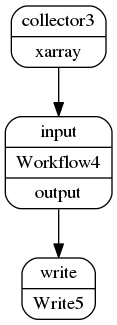

In [8]:
def createGraphWithProv():
    
    graph=createWorkflowGraph()
    #Location of the remote repository for runtime updates of the lineage traces. Shared among ProvenanceRecorder subtypes

    # Ranomdly generated unique identifier for the current run
    rid='JUP_SIMPLE_'+getUniqueId()

    
    # Finally, provenance enhanced graph is prepared:
    print prov_profile

    ##Initialise provenance storage in files:
    #profile_prov_run(graph,None,provImpClass=(ProvenancePE,),componentsType={'CorrCoef':(ProvenancePE,)},username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='file')
                  # skip_rules={'CorrCoef':{'ro':{'$lt':0}}})

    #Initialise provenance storage to service:
    profile_prov_run(graph, 
                     None,
                     provImpClass=(ProvenancePE,),
                     username=prov_profile['username'],
                     runId=rid,
                     w3c_prov=prov_profile['w3c_prov'],
                     description=prov_profile['description'],
                     workflowName=prov_profile['workflowName'],
                     workflowId=prov_profile['workflowId'],
                     save_mode=prov_profile['save_mode'],
                     componentsType=prov_profile['componentsType']
                    )
                   #skip_rules={'CorrCoef':{'ro':{'$lt':0}}})

    #clustersRecorders={'record0':ProvenanceRecorderToFileBulk,'record1':ProvenanceRecorderToFileBulk,'record2':ProvenanceRecorderToFileBulk,'record6':ProvenanceRecorderToFileBulk,'record3':ProvenanceRecorderToFileBulk,'record4':ProvenanceRecorderToFileBulk,'record5':ProvenanceRecorderToFileBulk}
    #Initialise provenance storage to sensors and Files:
    #profile_prov_run(graph,ProvenanceRecorderToFile,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor')
    #clustersRecorders=clustersRecorders)
    
    #Initialise provenance storage to sensors and service:
    #profile_prov_run(graph,ProvenanceRecorderToService,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor')
   
    #Summary view on each component
    #profile_prov_run(graph,ProvenanceTimedSensorToService,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor')
   
   
   
    #Configuring provenance feedback-loop
    #profile_prov_run(graph,ProvenanceTimedSensorToService,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor',feedbackPEs=['Source','MaxClique'])
   
   
    #Initialise provenance storage end associate a Provenance type with specific components:
    #profile_prov_run(graph,provImpClass=ProvenancePE,componentsType={'Source':(ProvenanceStock,)},username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='service')

    #
    return graph


graph=createGraphWithProv()

display(graph)

The workflow is rerun with provenace enabled.

In [9]:
runExampleWorkflow()

input_simple.json
{'collector': [{'input': ['data/newA.nc', 'data/newOut.nc']}]}
SETTING NAME: SimpleProcessingPE
collector3: read_process
collector3: {'input': ['data/newA.nc', 'data/newOut.nc']}
Workflow4: Workflow_process
{'contact_email_2': 'milka.radojevic@cerfacs.fr', 'contact_email_1': 'christian.page@cerfacs.fr', 'in_var_driving_ensemble_member': 'r1i1p1', 'software_reference': 'ICCLIM Documentation 3.0: https://media.readthedocs.org/pdf/icclim/latest/icclim.pdf', 'keywords': 'CLIP-C,Tier 1,vDTR,rcp85,SMHI-RCA4', 'Conventions': 'CF-1.6', 'in_var_driving_experiment_id': 'rcp85', 'in_var_model_version_id': 'v1', 'in_var_institution_id': 'SMHI', 'version': '2015-06', 'software_project': 'IS-ENES: climate for impact web portal', 'in_var_project_id': 'CORDEX', 'method': 'CLIVAR panel ETCCDI', 'description': 'Tier 1: vDTR. Multi-year period of records.', 'in_var_domain': 'EUR-11', 'in_var_driving_model_id': 'MPI-M-MPI-ESM-LR', 'institution': 'CERFACS', 'geospatial_lon_max': '64.9644'

The following link requires a local tomcat server to proxy to the provenance depo.


http://localhost:8180/provenance-explorer/html/view.jsp

An example of the above W3C prov xml can be viewed using:

https://provenance.ecs.soton.ac.uk/store/documents/115532.svg

The End